# 01.1e: Pairwise Cosine Similarities

**Goal:** Compute pairwise cosine similarities across different token populations to understand angular density.

We'll compute pairwise cosines for:
1. **Random baseline**: 10,000 random token pairs from full vocabulary
2. **First 256 tokens**: All pairs among the primitive tokens (likely basic UTF-8 characters)
3. **Token ID bands**: Sample 1,000 tokens from each band, compute within-band pairwise cosines
   - Band 1: 0-10k (ultra-frequent)
   - Band 2: 10k-50k (common)
   - Band 3: 50k-100k (less common)
   - Band 4: 100k-151,936 (rare)
4. **Full jet**: All pairwise cosines within the jet (3,055 tokens)

This reveals:
- Baseline angular density of the full vocabulary
- Whether primitive tokens cluster or spread
- Frequency effects on angular structure
- Whether the jet is exceptionally dense

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
RESULTS_DIR = "../data/results"
RANDOM_SEED = 42

# Random baseline
NUM_RANDOM_PAIRS = 10_000

# Token ID bands (start, end)
BANDS = [
    (0, 10_000),
    (10_000, 50_000),
    (50_000, 100_000),
    (100_000, 151_936)
]
NUM_SAMPLES_PER_BAND = 1_000

## Imports

In [2]:
import torch
import numpy as np
import pandas as pd
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Load Data

In [3]:
# Load original gamma (uncentered)
gamma_path = Path(TENSOR_DIR) / "gamma_qwen3_4b_instruct_2507.safetensors"
gamma = load_file(gamma_path)['gamma']

N, d = gamma.shape

print(f"Loaded γ (original, uncentered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

# Normalize gamma for cosine similarity (so we can use dot products)
print("Normalizing gamma for efficient cosine computation...")
gamma_normalized = gamma / gamma.norm(dim=1, keepdim=True)
print("Done.")

Loaded γ (original, uncentered):
  Tokens: 151,936
  Dimensions: 2,560

Normalizing gamma for efficient cosine computation...
Done.


## Helper Function: Compute Pairwise Cosines

In [4]:
def compute_pairwise_cosines(indices, gamma_norm, description):
    """
    Compute all pairwise cosine similarities for a set of token indices.
    
    Args:
        indices: Tensor of token IDs
        gamma_norm: Normalized gamma matrix
        description: String description for progress bar
    
    Returns:
        1D tensor of pairwise cosines (upper triangle, excluding diagonal)
    """
    n = len(indices)
    print(f"\n{description}")
    print(f"  Computing {n*(n-1)//2:,} pairwise cosines for {n:,} tokens...")
    
    # Extract subset
    subset = gamma_norm[indices]
    
    # Compute full similarity matrix: subset @ subset.T
    sim_matrix = subset @ subset.T
    
    # Extract upper triangle (excluding diagonal)
    # Use torch.triu to get upper triangular part
    upper_triangle_mask = torch.triu(torch.ones(n, n, dtype=torch.bool), diagonal=1)
    cosines = sim_matrix[upper_triangle_mask]
    
    print(f"  Mean: {cosines.mean().item():.6f}")
    print(f"  Std: {cosines.std().item():.6f}")
    print(f"  Min: {cosines.min().item():.6f}")
    print(f"  Max: {cosines.max().item():.6f}")
    
    return cosines

## 1. Random Baseline

Sample random pairs from the full vocabulary to establish baseline angular density.

In [5]:
print(f"Sampling {NUM_RANDOM_PAIRS:,} random token pairs...")

# Sample random pairs (without replacement)
random_indices_1 = torch.randint(0, N, (NUM_RANDOM_PAIRS,))
random_indices_2 = torch.randint(0, N, (NUM_RANDOM_PAIRS,))

# Compute cosines for these pairs
random_cosines = (gamma_normalized[random_indices_1] * gamma_normalized[random_indices_2]).sum(dim=1)

print(f"\nRandom baseline ({NUM_RANDOM_PAIRS:,} pairs):")
print(f"  Mean: {random_cosines.mean().item():.6f}")
print(f"  Std: {random_cosines.std().item():.6f}")
print(f"  Min: {random_cosines.min().item():.6f}")
print(f"  Max: {random_cosines.max().item():.6f}")

# Store for later comparison
results = {
    'random_baseline': {
        'cosines': random_cosines.cpu().numpy(),
        'mean': random_cosines.mean().item(),
        'std': random_cosines.std().item(),
        'count': len(random_cosines)
    }
}

Sampling 10,000 random token pairs...

Random baseline (10,000 pairs):
  Mean: 0.086932
  Std: 0.061853
  Min: -0.311835
  Max: 1.000002


## 2. First 256 Tokens

Compute all pairwise cosines for the first 256 tokens (primitive building blocks).

In [6]:
first_256_indices = torch.arange(256)
first_256_cosines = compute_pairwise_cosines(
    first_256_indices, 
    gamma_normalized,
    "First 256 tokens (primitives):"
)

results['first_256'] = {
    'cosines': first_256_cosines.cpu().numpy(),
    'mean': first_256_cosines.mean().item(),
    'std': first_256_cosines.std().item(),
    'count': len(first_256_cosines)
}


First 256 tokens (primitives):
  Computing 32,640 pairwise cosines for 256 tokens...
  Mean: 0.032506
  Std: 0.134186
  Min: -0.611825
  Max: 1.000002


## 3. Token ID Bands

Sample tokens from different ID ranges and compute within-band pairwise cosines.

In [7]:
for i, (start, end) in enumerate(BANDS, 1):
    # Sample tokens from this band
    band_size = end - start
    n_samples = min(NUM_SAMPLES_PER_BAND, band_size)
    
    # Random sample without replacement
    sample_offsets = torch.randperm(band_size)[:n_samples]
    band_indices = sample_offsets + start
    
    band_cosines = compute_pairwise_cosines(
        band_indices,
        gamma_normalized,
        f"Band {i}: tokens {start:,}-{end:,} ({n_samples:,} sampled):"
    )
    
    results[f'band_{i}'] = {
        'cosines': band_cosines.cpu().numpy(),
        'mean': band_cosines.mean().item(),
        'std': band_cosines.std().item(),
        'count': len(band_cosines),
        'range': (start, end)
    }


Band 1: tokens 0-10,000 (1,000 sampled):
  Computing 499,500 pairwise cosines for 1,000 tokens...
  Mean: 0.022239
  Std: 0.031966
  Min: -0.288658
  Max: 0.873775

Band 2: tokens 10,000-50,000 (1,000 sampled):
  Computing 499,500 pairwise cosines for 1,000 tokens...
  Mean: 0.058903
  Std: 0.031038
  Min: -0.062622
  Max: 0.792498

Band 3: tokens 50,000-100,000 (1,000 sampled):
  Computing 499,500 pairwise cosines for 1,000 tokens...
  Mean: 0.090255
  Std: 0.030073
  Min: -0.053923
  Max: 0.753168

Band 4: tokens 100,000-151,936 (1,000 sampled):
  Computing 499,500 pairwise cosines for 1,000 tokens...
  Mean: 0.133465
  Std: 0.100785
  Min: -0.031301
  Max: 1.000003


## 4. Full Jet

Compute all pairwise cosines within the jet (3,055 tokens).

In [8]:
# Load jet mask
jet_mask_path = Path(TENSOR_DIR) / "jet_mask.safetensors"
jet_mask = load_file(jet_mask_path)['jet_mask']

jet_indices = torch.where(jet_mask)[0]

jet_cosines = compute_pairwise_cosines(
    jet_indices,
    gamma_normalized,
    "Full jet:"
)

results['jet'] = {
    'cosines': jet_cosines.cpu().numpy(),
    'mean': jet_cosines.mean().item(),
    'std': jet_cosines.std().item(),
    'count': len(jet_cosines)
}


Full jet:
  Computing 4,664,985 pairwise cosines for 3,055 tokens...
  Mean: 0.188327
  Std: 0.090796
  Min: -0.164580
  Max: 0.878862


## Summary Table

In [9]:
print("\n" + "="*80)
print("SUMMARY: Pairwise Cosine Similarities")
print("="*80 + "\n")

summary_data = []
for name, data in results.items():
    summary_data.append({
        'Population': name,
        'Count': data['count'],
        'Mean': f"{data['mean']:.6f}",
        'Std': f"{data['std']:.6f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print()

# Compute relative densities (compared to random baseline)
baseline_mean = results['random_baseline']['mean']
print("\nRelative angular density (vs random baseline):\n")
for name, data in results.items():
    if name != 'random_baseline':
        ratio = data['mean'] / baseline_mean
        print(f"  {name:20s}: {ratio:6.2f}× baseline")


SUMMARY: Pairwise Cosine Similarities

     Population   Count     Mean      Std
random_baseline   10000 0.086932 0.061853
      first_256   32640 0.032506 0.134186
         band_1  499500 0.022239 0.031966
         band_2  499500 0.058903 0.031038
         band_3  499500 0.090255 0.030073
         band_4  499500 0.133465 0.100785
            jet 4664985 0.188327 0.090796


Relative angular density (vs random baseline):

  first_256           :   0.37× baseline
  band_1              :   0.26× baseline
  band_2              :   0.68× baseline
  band_3              :   1.04× baseline
  band_4              :   1.54× baseline
  jet                 :   2.17× baseline


## Visualize Distributions

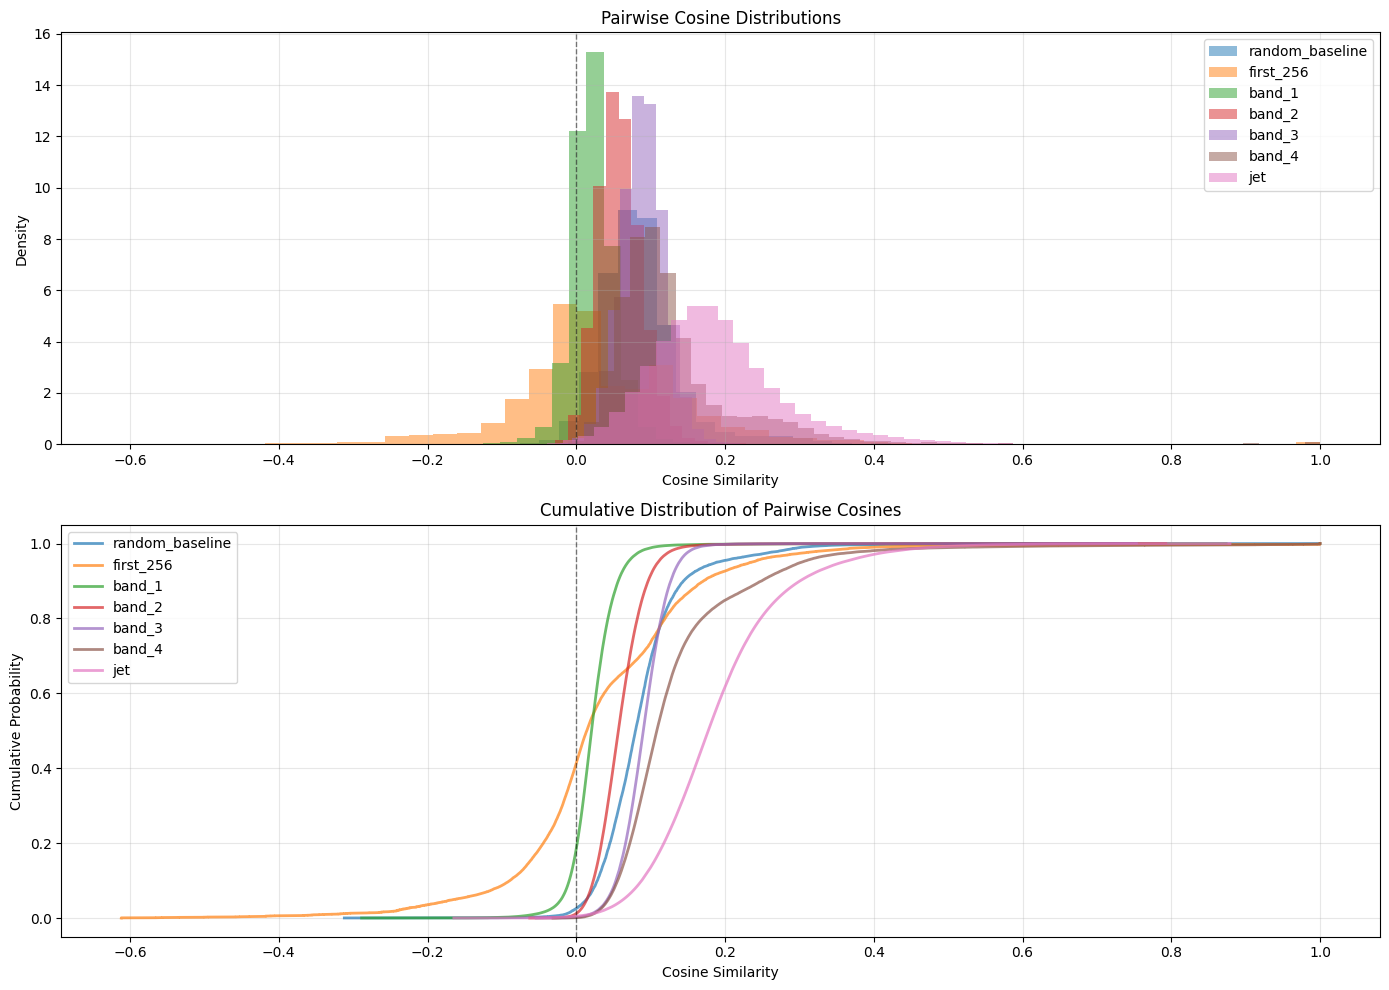


Histogram shows density of pairwise cosines.
Cumulative plot shows what fraction of pairs have cosine < threshold.


In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=100)

# Histogram
ax = axes[0]
for name, data in results.items():
    ax.hist(data['cosines'], bins=50, alpha=0.5, label=name, density=True)
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title('Pairwise Cosine Distributions')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Cumulative distribution
ax = axes[1]
for name, data in results.items():
    sorted_cosines = np.sort(data['cosines'])
    cumulative = np.arange(1, len(sorted_cosines) + 1) / len(sorted_cosines)
    ax.plot(sorted_cosines, cumulative, label=name, linewidth=2, alpha=0.7)
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Cumulative Probability')
ax.set_title('Cumulative Distribution of Pairwise Cosines')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print("\nHistogram shows density of pairwise cosines.")
print("Cumulative plot shows what fraction of pairs have cosine < threshold.")

## Save Results

In [11]:
# Save summary statistics to CSV
output_path = Path(RESULTS_DIR) / "pairwise_cosines_summary.csv"
summary_df.to_csv(output_path, index=False)
print(f"Saved summary to: {output_path}")

# Save full distributions as npz
cosines_dict = {name: data['cosines'] for name, data in results.items()}
output_path_npz = Path(RESULTS_DIR) / "pairwise_cosines.npz"
np.savez(output_path_npz, **cosines_dict)
print(f"Saved full distributions to: {output_path_npz}")

Saved summary to: ../data/results/pairwise_cosines_summary.csv
Saved full distributions to: ../data/results/pairwise_cosines.npz


## Summary

Computed pairwise cosine similarities for different token populations.

**Key findings:**
- Random baseline: Mean cosine ≈ ??? (typical angular separation in 2560D)
- First 256 tokens: Mean cosine ≈ ??? (primitives are ???)
- Token ID bands: Mean cosines show ??? trend with frequency
- Jet: Mean cosine ≈ ??? (???× denser than baseline)

**Interpretation:**
- Baseline near 0 is expected (random vectors in high-D are nearly orthogonal)
- Higher means indicate angular clustering (tokens point in similar directions)
- Jet's relative density reveals whether it's exceptionally clustered or typical